Step 1 | Importing Necessary Libraries

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [ ]:
# Initialize Plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# Configure Seaborn plot styles
sns.set(rc={'axes.facecolor': 'white'}, style='darkgrid')

Loading the Dataset

In [ ]:
df = pd.read_csv('/content/data.csv', encoding="ISO-8859-1")

Dataset Description:

| __Variable__   | __Description__ |
|     :---       |       :---      |      
| __InvoiceNo__  | Code representing each unique transaction.  If this code starts with letter 'c', it indicates a cancellation. |
| __StockCode__  | Code uniquely assigned to each distinct product. |
| __Description__| Description of each product. |
| __Quantity__   | The number of units of a product in a transaction. |
| __InvoiceDate__| The date and time of the transaction. |
| __UnitPrice__  | The unit price of the product in sterling. |
| __CustomerID__ | Identifier uniquely assigned to each customer. |
| __Country__    | The country of the customer. |


<a id="initial_analysis"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Initial Data Analysis</p>


Dataset Overview


Perform a preliminary analysis to understand the structure and types of data columns:

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338924 entries, 0 to 338923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    338924 non-null  object 
 1   StockCode    338924 non-null  object 
 2   Description  337739 non-null  object 
 3   Quantity     338923 non-null  float64
 4   InvoiceDate  338923 non-null  object 
 5   UnitPrice    338923 non-null  float64
 6   CustomerID   246728 non-null  float64
 7   Country      338923 non-null  object 
dtypes: float64(3), object(5)
memory usage: 20.7+ MB


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=black>Inferences:</font></h3>
    
The dataset consists of 541,909 entries and 8 columns. Here is a brief overview of each column:

- __`InvoiceNo`__: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction.
   
    
- __`StockCode`__: An object data type column representing the product code for each item.

    
- __`Description`__: This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.

    
- __`Quantity`__: This is an integer column indicating the quantity of products purchased in each transaction.
   

- __`InvoiceDate`__: A datetime column that records the date and time of each transaction.

    
- __`UnitPrice`__: A float column representing the unit price of each product.

    
- __`CustomerID`__: A float column that contains the customer ID for each transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.

    
- __`Country`__: An object column recording the country where each transaction took place.

From a preliminary overview, it seems that there are missing values in the `Description` and `CustomerID` columns which need to be addressed. The `InvoiceDate` column is already in datetime format, which will facilitate further time series analysis. We also observe that a single customer can have multiple transactions as inferred from the repeated `CustomerID` in the initial rows.

The next steps include deeper data cleaning and preprocessing.

Step 2.2 | Summary Statistics


In [ ]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,338923.0,9.688956,189.213581,-74215.00,1.00,3.0,10.00,74215.0
UnitPrice,338923.0,4.830830,110.351838,-11062.06,1.25,2.1,4.13,38970.0
CustomerID,246728.0,15278.042180,1726.518155,12346.00,13862.00,15149.0,16813.00,18287.0


In [ ]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,338924,17300,558475,705
StockCode,338924,3833,85123A,1705
Description,337739,3873,WHITE HANGING HEART T-LIGHT HOLDER,1745
InvoiceDate,338923,15639,6/29/2011 15:58,705
Country,338923,37,United Kingdom,309194


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Inferences:</font></h3>


- __`Quantity`__:
   - The average quantity of products in a transaction is approximately 9.55.
   - The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders, which need to be handled appropriately.
   - The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

    
- __`UnitPrice`__:
   - The average unit price of the products is approximately 4.61.
   - The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.
   - Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

    
- __`CustomerID`__:
   - There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.
   - The Customer IDs range from 12346 to 18287, helping in identifying unique customers.

    
- __`InvoiceNo`__:
   - There are 25900 unique invoice numbers, indicating 25900 separate transactions.
   - The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.

    
- __`StockCode`__:
   - There are 4070 unique stock codes representing different products.
   - The most frequent stock code is 85123A, appearing 2313 times in the dataset.

    
- __`Description`__:
   - There are 4223 unique product descriptions.
   - The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.
   - There are some missing values in this column which need to be treated.

    
- __`Country`__:
   - The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.

<a id="data_cleaning"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 |  Data Cleaning & Transformation</p>


Handling Missing Values

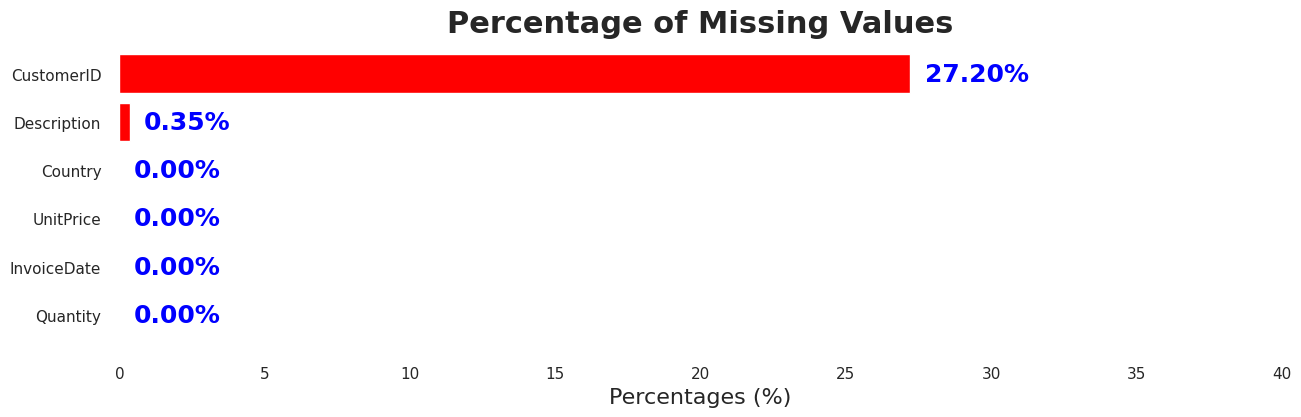

In [ ]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='BLUE')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=#000>Handling Missing Values Strategy:</font></h3>

- __`CustomerID` (24.93% missing values)__
   - Since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing `CustomerID`s seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

    
- __`Description` (0.27% missing values)__
   - There are inconsistencies in the data where the same `StockCode` does not always have the same `Description`. This indicates data quality issues and potential errors in the product descriptions. The missing percentage is quite low, so we need to remove the rows with missing `Description`s to avoid errors and inconsistencies.
   


In [ ]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56.0,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4.0,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2.0,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

Handling Duplicates

In [ ]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom


Handling Duplicates Strategy:
    
The presence of completely identical rows, including identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. So we need to remove these completely identical duplicate rows from the dataset.

In [ ]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 2617 duplicate rows that need to be removed.


In [ ]:
# Getting the number of rows in the dataframe
df.shape[0]

244111

Treating Cancelled Transactions


We will identify cancelled transactions by filtering the rows where the `InvoiceNo` starts with "C".

In [ ]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,5799.000000,5799.000000
mean,-25.710295,22.209971
std,984.921267,542.867173
min,-74215.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


Inferences :

- All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled. The `UnitPrice` column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.



Strategy for Handling Cancelled Transactions:
    
We need to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

- Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.
    
    
- Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.



In [ ]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.38%


Correcting StockCode Anomalies


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

First of all, lets find the number of unique stock codes and to plot the top 10 most frequent stock codes along with their percentage frequency:

In [ ]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3467


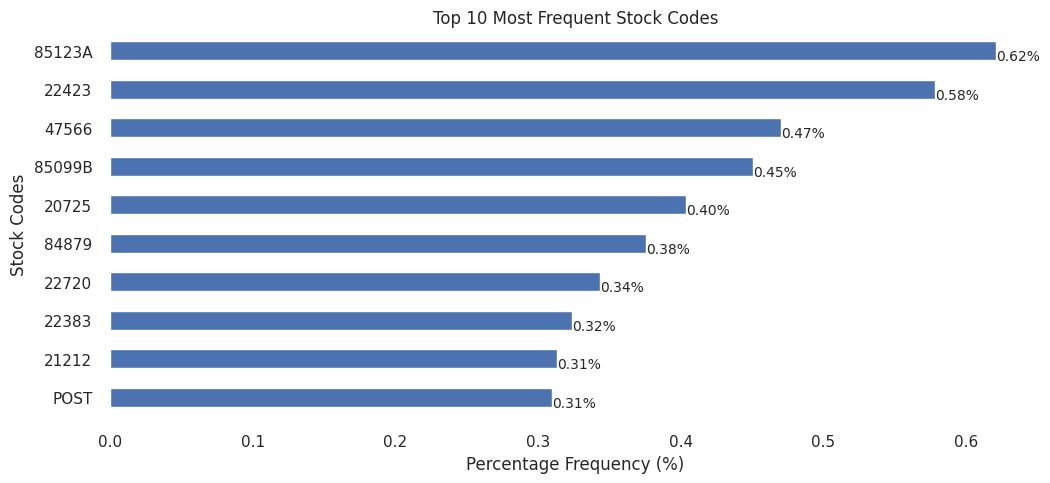

In [ ]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=black>Inferences on Stock Codes:</font></h3>

- __Product Variety__: The dataset contains 3684 unique stock codes.

    
- __Popular Items__: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

    
- __Stock Code Anomalies__: While most stock codes are composed of 5 or 6 characters, there are some anomalies like the code '__POST__'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products.

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
To delve deeper into identifying these anomalies, let's explore the frequency of the number of numeric characters in the stock codes, which can provide insights into the nature of these unusual entries:

In [ ]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3459
0       7
1       1
Name: count, dtype: int64


Inference:


- A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format.

    
- There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character.

In [ ]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
Let's calculate the percentage of records with these anomalous stock codes:    

In [ ]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.50%


Inference:

Based on the analysis, we find that a very small proportion of the records, __0.48%__, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (__only 8 out of 3684__).

These codes seem to represent non-product transactions like "__BANK CHARGES__", "__POST__" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system. Tt would be the best to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions.

In [ ]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [ ]:
# Getting the number of rows in the dataframe
df.shape[0]

242900

Cleaning Description Column

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
First, we need to calculate the occurrence count of each unique description in the dataset. Then, plot the top 30 descriptions. This visualization will give a clear view of the highest occurring descriptions in the dataset:

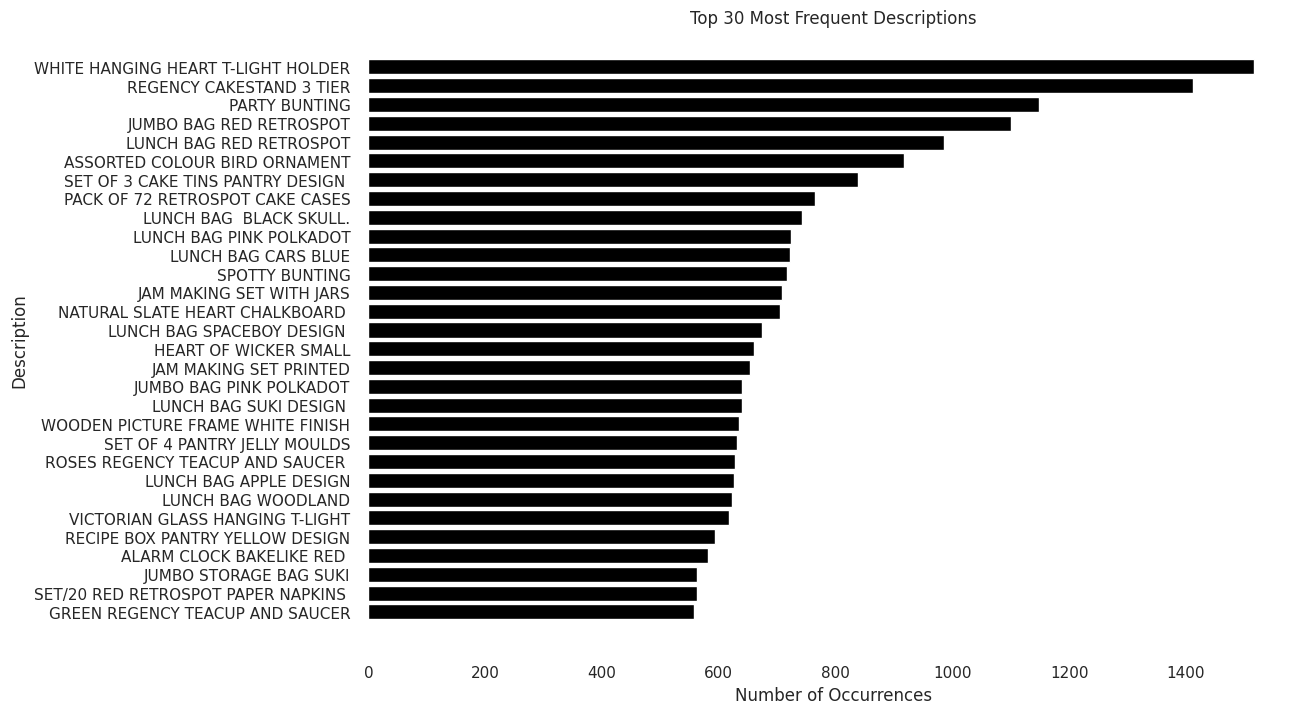

In [ ]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='black')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

Inferences :

- The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
       
    
- All the descriptions are in uppercase, which might be a standardized format. However, it would be better to check if there are descriptions entered in lowercase or a mix of case styles.

In [ ]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm


Inference:
- Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "__Next Day Carriage__" and "__High Resolution Image__". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

Strategy:

- __Step 1__: Remove the rows where the descriptions contain service-related information like "__Next Day Carriage__" and "__High Resolution Image__".

    
- __Step 2__: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset.

In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.01%


In [ ]:
# Getting the number of rows in the dataframe
df.shape[0]

242867

Treating Zero Unit Prices


In [ ]:
df['UnitPrice'].describe()

,UnitPrice
count,242867.000000
mean,2.996495
std,5.088212
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


Inference:

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error.

In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,20.000000
mean,51.800000
std,72.865124
min,1.000000
25%,3.500000
50%,13.500000
75%,84.000000
max,240.000000


Inferences :

- The transactions with a unit price of zero are relatively few in number (33 transactions). These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation. Including these transactions in the clustering analysis might introduce noise, so we should remove these transactions from the dataset.

In [ ]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

Outlier Treatment


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers __after the feature engineering phase__ where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [ ]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [ ]:
# Getting the number of rows in the dataframe
df.shape[0]

242847

<a id="feature_engineering"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Feature Engineering</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data:

<a id="rfm_features"></a>
# <b><span style='color:#000'>Step 4.1 |</span><span style='color:#000'> RFM Features</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

- __Recency (R):__ This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

    
- __Frequency (F):__ This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

    
- __Monetary (M):__ This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

    
Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

<a id="recency"></a>
## <b><span style='color:#000'>Step 4.1.1 |</span><span style='color:#000'> Recency (R)</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. Here, I am going to define the following feature:

- __Days Since Last Purchas__: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [ ]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
Now, __customer_data__ dataframe contains the __`Days_Since_Last_Purchase`__ feature:

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,238
1,12347.0,42
2,12348.0,161
3,12350.0,223
4,12352.0,175


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Note: </font></h3>
    
- I've named the customer-centric dataframe as __customer_data__, which will eventually contain all the customer-based features we plan to create.

<a id="frequency"></a>
## <b><span style='color:#000'>Step 4.1.2 |</span><span style='color:#000'> Frequency (F)</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:

- __Total Transactions__: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

    

- __Total Products Purchased__: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

    
These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [ ]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,238,2,0.0
1,12347.0,42,5,1590.0
2,12348.0,161,3,2116.0
3,12350.0,223,1,196.0
4,12352.0,175,5,186.0


<a id="monetary"></a>
## <b><span style='color:#000'>Step 4.1.3 |</span><span style='color:#000'> Monetary (M)</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

- __Total Spend__: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of `UnitPrice` and `Quantity` for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

    
- __Average Transaction Value__: This feature is calculated as the __Total Spend__ divided by the __Total Transactions__ for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [ ]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,238,2,0.0,0.00,0.000
1,12347.0,42,5,1590.0,2790.86,558.172
2,12348.0,161,3,2116.0,1167.24,389.080
3,12350.0,223,1,196.0,294.40,294.400
4,12352.0,175,5,186.0,521.18,104.236


<a id="product_diversity"></a>
# <b><span style='color:#000'>Step 4.2 |</span><span style='color:#000'> Product Diversity</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

- __Unique Products Purchased__: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [ ]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,238,2,0.0,0.00,0.000,1
1,12347.0,42,5,1590.0,2790.86,558.172,82
2,12348.0,161,3,2116.0,1167.24,389.080,21
3,12350.0,223,1,196.0,294.40,294.400,16
4,12352.0,175,5,186.0,521.18,104.236,24


<a id="behaviroal_features"></a>
# <b><span style='color:#000'>Step 4.3 |</span><span style='color:#000'> Behavioral Features</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

- __Average Days Between Purchases__: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

    
- __Favorite Shopping Day__: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

    
- __Favorite Shopping Hour__: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

    
By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [ ]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,238,2,0.0,0.00,0.000,1,0.000000,1,10
1,12347.0,42,5,1590.0,2790.86,558.172,82,1.934959,1,14
2,12348.0,161,3,2116.0,1167.24,389.080,21,4.583333,3,19
3,12350.0,223,1,196.0,294.40,294.400,16,0.000000,2,16
4,12352.0,175,5,186.0,521.18,104.236,24,0.871795,1,16


<a id="geographical_features"></a>
# <b><span style='color:#000'>Step 4.4 |</span><span style='color:#000'> Geographic Features</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:

- __Country__: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [ ]:
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
United Kingdom,0.885838
Germany,0.024678
France,0.020264
EIRE,0.018048
Netherlands,0.006696


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Inference: </font></h3>
    
Given that a substantial portion (__89%__) of transactions are originating from the __United Kingdom__, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Methodology: </font></h3>

- First, I will group the data by `CustomerID` and `Country` and calculate the number of transactions per country for each customer.

- Next, I will identify the main country for each customer (the country from which they have the maximum transactions).
    
- Then, I will create a binary column indicating whether the customer is from the UK or not.
    
- Finally, I will merge this information with the `customer_data` dataframe to include the new feature in our analysis.

In [ ]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,238,2,0.0,0.00,0.000,1,0.000000,1,10,1
1,12347.0,42,5,1590.0,2790.86,558.172,82,1.934959,1,14,0
2,12348.0,161,3,2116.0,1167.24,389.080,21,4.583333,3,19,0
3,12350.0,223,1,196.0,294.40,294.400,16,0.000000,2,16,0
4,12352.0,175,5,186.0,521.18,104.236,24,0.871795,1,16,0


In [ ]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3024
0,334


<a id="cancellation_insights"></a>
# <b><span style='color:#000'>Step 4.5 |</span><span style='color:#000'> Cancellation Insights</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

- __Cancellation Frequency__: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

    
- __Cancellation Rate__: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

By incorporating these cancellation insights into our dataset, we can build a more comprehensive view of customer behavior, which could potentially aid in creating more effective and nuanced customer segmentation.


In [ ]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,238,2,0.0,0.00,0.000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,42,5,1590.0,2790.86,558.172,82,1.934959,1,14,0,0.0,0.0
2,12348.0,161,3,2116.0,1167.24,389.080,21,4.583333,3,19,0,0.0,0.0
3,12350.0,223,1,196.0,294.40,294.400,16,0.000000,2,16,0,0.0,0.0
4,12352.0,175,5,186.0,521.18,104.236,24,0.871795,1,16,0,1.0,0.2


<a id="seasonality_trends"></a>
# <b><span style='color:#000'>Step 4.6 |</span><span style='color:#000'> Seasonality & Trends</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this step, I will delve into the seasonality and trends in customers' purchasing behaviors, which can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the features I am looking to introduce:

- __Monthly_Spending_Mean__: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

    
- __Monthly_Spending_Std__: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

    
- __Spending_Trend__: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

By incorporating these detailed insights into our customer segmentation model, we can create more precise and actionable customer groups, facilitating the development of highly targeted marketing strategies and promotions.


In [ ]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,238,2,0.0,0.00,0.000,1,0.000000,1,10,1,1.0,0.5,0.000,0.000000,0.000
1,12347.0,42,5,1590.0,2790.86,558.172,82,1.934959,1,14,0,0.0,0.0,558.172,130.495277,-34.663
2,12348.0,161,3,2116.0,1167.24,389.080,21,4.583333,3,19,0,0.0,0.0,389.080,238.810442,-162.900
3,12350.0,223,1,196.0,294.40,294.400,16,0.000000,2,16,0,0.0,0.0,294.400,0.000000,0.000
4,12352.0,175,5,186.0,521.18,104.236,24,0.871795,1,16,0,1.0,0.2,260.590,50.784409,-71.820


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

We've done a great job so far! We have created a dataset that focuses on our customers, using a variety of new features that give us a deeper understanding of their buying patterns and preferences.

In [ ]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,238,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,42,5,1590,2790.86,558.172,82,1.934959,1,14,0,0,0.0,558.172,130.495277,-34.663
2,12348.0,161,3,2116,1167.24,389.08,21,4.583333,3,19,0,0,0.0,389.08,238.810442,-162.9
3,12350.0,223,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
4,12352.0,175,5,186,521.18,104.236,24,0.871795,1,16,0,1,0.2,260.59,50.784409,-71.82
5,12353.0,117,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
6,12354.0,145,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
7,12355.0,127,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
8,12356.0,158,2,1568,2429.08,1214.54,52,1.454545,1,9,0,0,0.0,1214.54,1036.731678,-1466.16
9,12358.0,63,1,98,404.86,404.86,11,0.0,1,10,0,0,0.0,404.86,0.0,0.0


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3358 entries, 0 to 3357
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3358 non-null   string 
 1   Days_Since_Last_Purchase        3358 non-null   Int64  
 2   Total_Transactions              3358 non-null   Int64  
 3   Total_Products_Purchased        3358 non-null   Int64  
 4   Total_Spend                     3358 non-null   Float64
 5   Average_Transaction_Value       3358 non-null   Float64
 6   Unique_Products_Purchased       3358 non-null   Int64  
 7   Average_Days_Between_Purchases  3358 non-null   Float64
 8   Day_Of_Week                     3358 non-null   Int32  
 9   Hour                            3358 non-null   Int32  
 10  Is_UK                           3358 non-null   Int64  
 11  Cancellation_Frequency          3358 non-null   Int64  
 12  Cancellation_Rate               33

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
Let's review the descriptions of the columns in our newly created `customer_data` dataset:

<div style="border-radius:10px; padding: 15px; font-size:130%; text-align:left">

<h2 align="left"><font color=#000>Customer Dataset Description:</font></h2>

| __Variable__                       | __Description__ |
|     :---                           |       :---      |
| __CustomerID__                     | Identifier uniquely assigned to each customer, used to distinguish individual customers. |
| __Days_Since_Last_Purchase__       | The number of days that have passed since the customer's last purchase. |
| __Total_Transactions__             | The total number of transactions made by the customer. |
| __Total_Products_Purchased__       | The total quantity of products purchased by the customer across all transactions. |
| __Total_Spend__                    | The total amount of money the customer has spent across all transactions. |
| __Average_Transaction_Value__      | The average value of the customer's transactions, calculated as total spend divided by the number of transactions. |
| __Unique_Products_Purchased__      | The number of different products the customer has purchased. |
| __Average_Days_Between_Purchases__ | The average number of days between consecutive purchases made by the customer. |
| __Day_Of_Week__                    | The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday). |
| __Hour__                           | The hour of the day when the customer prefers to shop, represented in a 24-hour format. |
| __Is_UK__                          | A binary variable indicating whether the customer is based in the UK (1) or not (0). |
| __Cancellation_Frequency__         | The total number of transactions that the customer has cancelled. |
| __Cancellation_Rate__              | The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions. |
| __Monthly_Spending_Mean__          | The average monthly spending of the customer. |
| __Monthly_Spending_Std__           | The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern. |
| __Spending_Trend__                 | A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend. |


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

We've done a great job so far! We have created a dataset that focuses on our customers, using a variety of new features that give us a deeper understanding of their buying patterns and preferences.

Now that our dataset is ready, we can move on to the next steps of our project. This includes looking at our data more closely to find any patterns or trends, making sure our data is in the best shape by checking for and handling any outliers, and preparing our data for the clustering process. All of these steps will help us build a strong foundation for creating our customer segments and, eventually, a personalized recommendation system.

<h3 align="left"><font color=#000>Let's dive in!</font></h3>

<a id="outlier_detection"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 5 | Outlier Detection and Treatment</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In this section, I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the __Isolation Forest__ algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Let's proceed with this approach:

In [ ]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,294.4,0.0,0.0,1,0


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
After applying the Isolation Forest algorithm, we have identified the outliers and marked them in a new column named `Is_Outlier`. We have also calculated the outlier scores which represent the anomaly score of each record.

Now let's visualize the distribution of these scores and the number of inliers and outliers detected by the model:

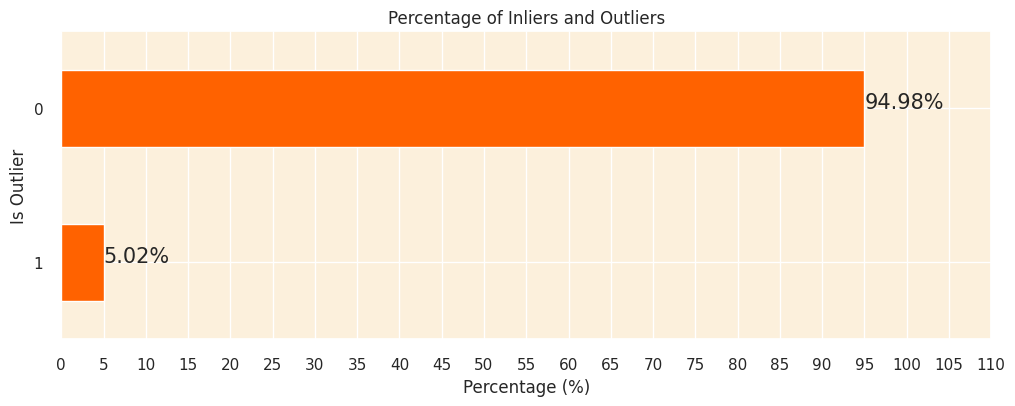

In [ ]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='red', color='black')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Inference: </font></h3>
    
From the above plot, we can observe that about 5% of the customers have been identified as outliers in our dataset. This percentage seems to be a reasonable proportion, not too high to lose a significant amount of data, and not too low to retain potentially noisy data points. It suggests that our isolation forest algorithm has worked well in identifying a moderate percentage of outliers, which will be critical in refining our customer segmentation.

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Strategy: </font></h3>

Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

Let's proceed with the following steps:

- Separate the identified outliers for further analysis and save them as a separate file (optional).
- Remove the outliers from the main dataset to prevent them from influencing the clustering process.
- Drop the `Outlier_Scores` and `Is_Outlier` columns as they were auxiliary columns used for the outlier detection process.

Let's implement these steps:

In [ ]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
We have successfully separated the outliers for further analysis and cleaned our main dataset by removing these outliers. This cleaned dataset is now ready for the next steps in our customer segmentation project, which includes scaling the features and applying clustering algorithms to identify distinct customer segments.

In [ ]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4067

<a id="correlation"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 6 | Correlation Analysis</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of __multicollinearity__, where __features are highly correlated__, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.

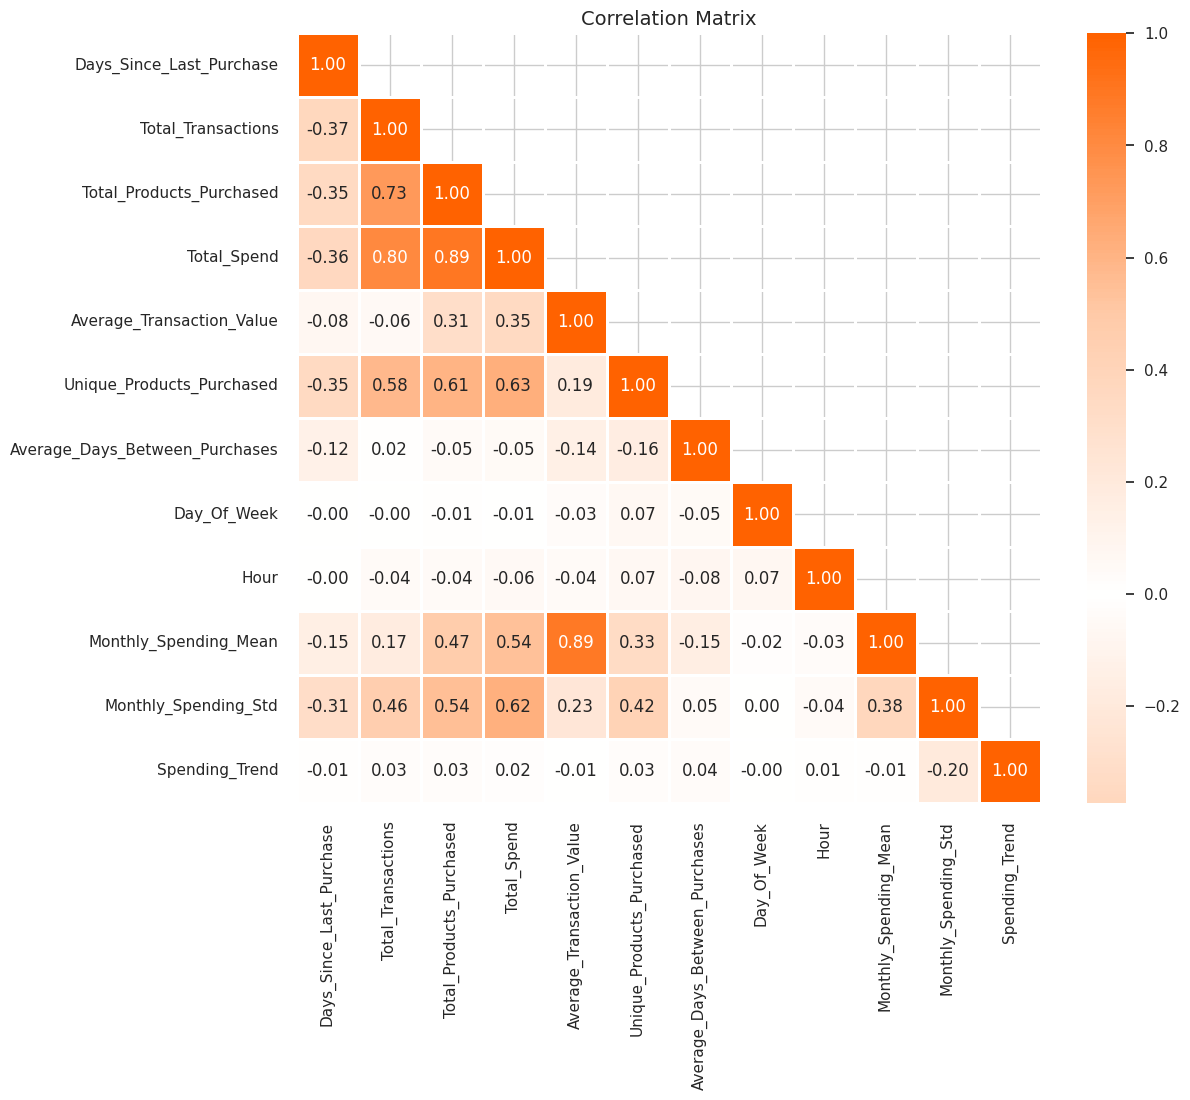

In [ ]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['black', '#ffcaa8', 'white', '#ffcaa8', 'black']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Inference: </font></h3>

Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

- `Monthly_Spending_Mean` and `Average_Transaction_Value`
    
    
- `Total_Spend` and `Total_Products_Purchased`

    
- `Total_Transactions` and `Total_Spend`
    
    
- `Cancellation_Rate` and `Cancellation_Frequency`
    
    
- `Total_Transactions` and `Total_Products_Purchased`

    
These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    

Before moving to the next steps, considering the impact of multicollinearity on KMeans clustering, it might be beneficial to treat this multicollinearity possibly through dimensionality reduction techniques such as PCA to create a set of uncorrelated variables. This will help in achieving more stable clusters during the KMeans clustering process.

<a id="scaling"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 7 | Feature Scaling</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA. Here's why:

  - __For K-means Clustering__: K-means relies heavily on the concept of '__distance__' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.
  
    
  - __For PCA__: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Methodology: </font></h3>
    
Therefore, to ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

- __CustomerID__: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
    
    
- __Is_UK__: This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.
    
    
- __Day_Of_Week__: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

    
I will proceed to scale the other features in the dataset to prepare it for PCA and K-means clustering.

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.352444,-0.477127,-0.794299,-0.838448,-1.340061,-0.916643,-0.431732,1,-1.088354,-1.377672,-0.732287,0.094350
1,12347.0,-0.901709,0.649223,2.135150,2.429107,1.580890,0.802317,-0.146739,1,0.650362,1.051989,1.324470,0.121434
2,12348.0,-0.166250,-0.026587,1.984983,0.251172,0.364507,-0.579592,1.106543,3,2.823757,0.040196,0.497143,-0.514723
3,12349.0,-0.740512,-0.702397,-0.043464,0.266569,5.574563,0.279888,-0.431732,0,-1.523033,4.373944,-0.732287,0.094350
4,12350.0,2.201323,-0.702397,-0.560706,-0.615253,0.056574,-0.663854,-0.431732,2,1.519720,-0.215945,-0.732287,0.094350


<a id="pca"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 8 | Dimensionality Reduction</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Why We Need Dimensionality Reduction? </font></h3>

- __Multicollinearity Detected__: In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.

    
- __Better Clustering with K-means__: Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.    
   
    
- __Noise Reduction__: By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stable clusters.    
   
    
- __Enhanced Visualization__: In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.
    
    
- __Improved Computational Efficiency__: Reducing the number of features can speed up the computation time during the modeling process, making our clustering algorithm more efficient.


Let's proceed to select an appropriate dimensionality reduction method to our data.

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Which Dimensionality Reduction Method? </font></h3>
  
    
In this step, we are considering the application of dimensionality reduction techniques to simplify our data while retaining the essential information. Among various methods such as KernelPCA, ICA, ISOMAP, TSNE, and UMAP, I am starting with **PCA (Principal Component Analysis)**. Here's why:

PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

However, it's essential to note that we are keeping our options open. After applying PCA, if we find that the first few components do not capture a significant amount of variance, indicating a loss of vital information, we might consider exploring other non-linear methods. These methods can potentially provide a more nuanced approach to dimensionality reduction, capturing complex patterns that PCA might miss, albeit at the cost of increased computational time and complexity.



<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Methodology </font></h3>

I will apply PCA on all the available components and plot the cumulative variance explained by them. This process will allow me to visualize how much variance each additional principal component can explain, thereby helping me to pinpoint the optimal number of components to retain for the analysis:

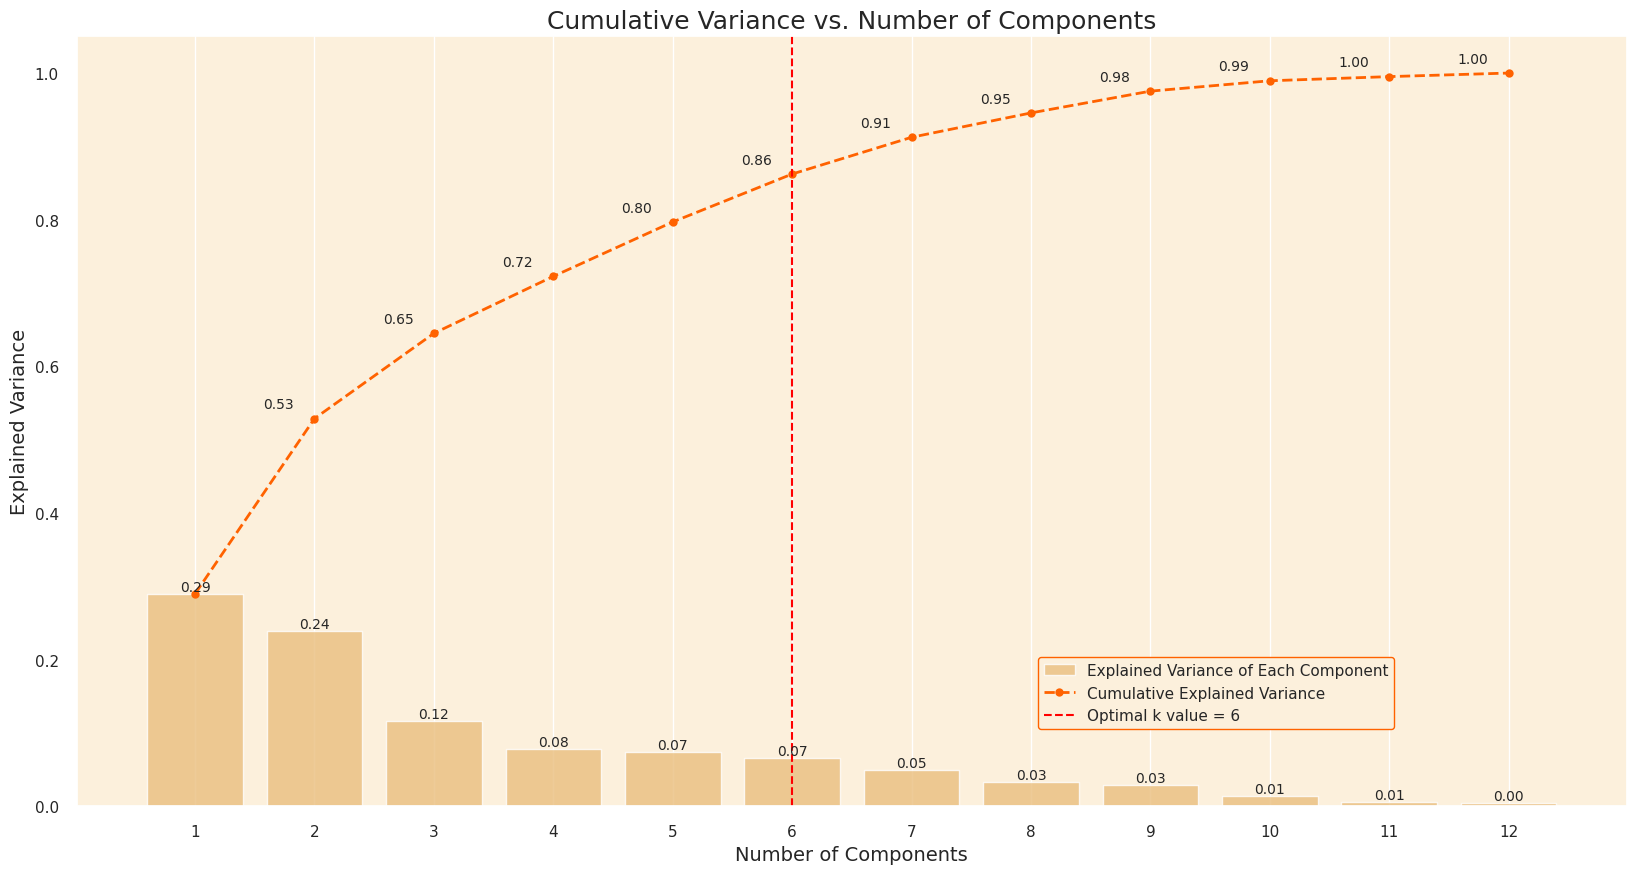

In [ ]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#000',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='black', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='black')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Conclusion </font></h3>
    
The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

- The first component explains approximately 28% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 61% of the variance, and so on.

    
To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "__elbow point__" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the __6th component__ (which __captures about 81% of the total variance__).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining __the first 6 components__ might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [ ]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [ ]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.771426,-1.532125,-0.495108,-0.170755,0.205202,-2.051918
12347.0,3.915344,-1.610655,0.570508,-0.333813,-0.028807,0.692857
12348.0,0.977024,0.497286,-0.221519,-0.504626,0.728606,2.566880
12349.0,2.548679,-2.881282,6.038188,1.246574,-1.667215,0.377303
12350.0,-1.874153,-0.450169,1.012284,-1.398265,0.546977,0.194659


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA:

In [ ]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.234775,-0.000048,0.236576,-0.128583,0.095585,-0.394858
Total_Transactions,0.371207,-0.002161,-0.376716,-0.090971,-0.000817,-0.159438
Total_Products_Purchased,0.437164,-0.014400,-0.089319,-0.046700,-0.044642,-0.092531
Total_Spend,0.460150,-0.012262,-0.075102,-0.022756,-0.037533,-0.089126
Average_Transaction_Value,0.228349,-0.030854,0.636293,0.108726,-0.133627,0.152129
Unique_Products_Purchased,0.361511,0.043582,-0.111905,-0.267861,0.058403,-0.046964
Average_Days_Between_Purchases,-0.040821,-0.038556,-0.278123,0.570791,-0.334268,0.487457
Day_Of_Week,0.013161,0.995599,0.024180,0.072338,-0.039404,-0.016439
Hour,-0.020413,0.058645,-0.004633,-0.574727,0.268903,0.720406
Monthly_Spending_Mean,0.318806,-0.024888,0.536639,0.078336,-0.099170,0.111443


<a id="kmeans"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 9 | K-Means Clustering</p>

<a id="optimal_k"></a>
# <b><span style='color:#000'>Step 9.1 |</span><span style='color:#000'> Determining the Optimal Number of Clusters</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

* __Elbow Method__

* __Silhouette Method__

    
It's common to utilize both methods in practice to corroborate the results.

<a id="elbow"></a>
## <b><span style='color:#000'>Step 9.1.1 |</span><span style='color:#000'> Elbow Method</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=#000>Utilizing the YellowBrick Library</font></h3>

In this section, I will employ the __YellowBrick__ library to facilitate the implementation of the __Elbow method__. YellowBrick, an extension of the Scikit-Learn API, is renowned for its ability to rapidly generate insightful visualizations in the field of machine learning.

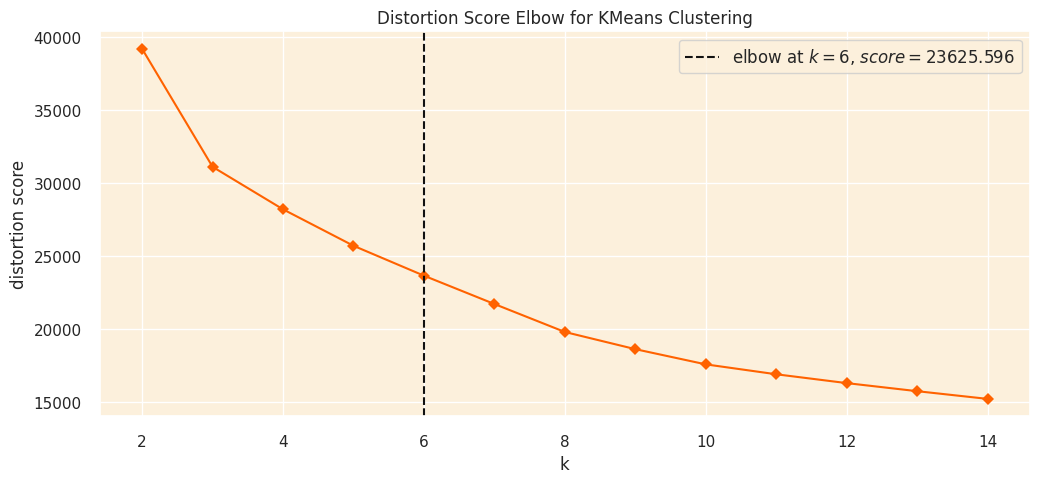

In [ ]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['black'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=black>Optimal k Value: Elbow Method Insights</font></h3>

The optimal value of k for the KMeans clustering algorithm can be found at the __elbow point__. Using the YellowBrick library for the Elbow method, we observe that the suggested optimal k value is __5__. However, __we don't have a very distinct elbow point in this case__, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that __the optimum value of k could be between 3 and 7__. To choose the best k within this range, we can employ the __silhouette analysis__, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

<a id="silhouette"></a>
## <b><span style='color:#000'>Step 9.1.2 |</span><span style='color:#000'> Silhouette Method</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=black>Methodology</font></h3>
    
In the following analysis:

- I will initially choose a range of 2-6 for the number of clusters (k) based on the Elbow method from the previous section. Next, I will plot __Silhouette scores__ for each k value to determine the one with the highest score.


- Subsequently, to fine-tune the selection of the most appropriate k, I will generate __Silhouette plots__ that visually display the __silhouette coefficients for each data point within various clusters__.


The __YellowBrick__ library will be utilized once again to create these plots and facilitate a comparative analysis.

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#000', edgecolor='#000', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

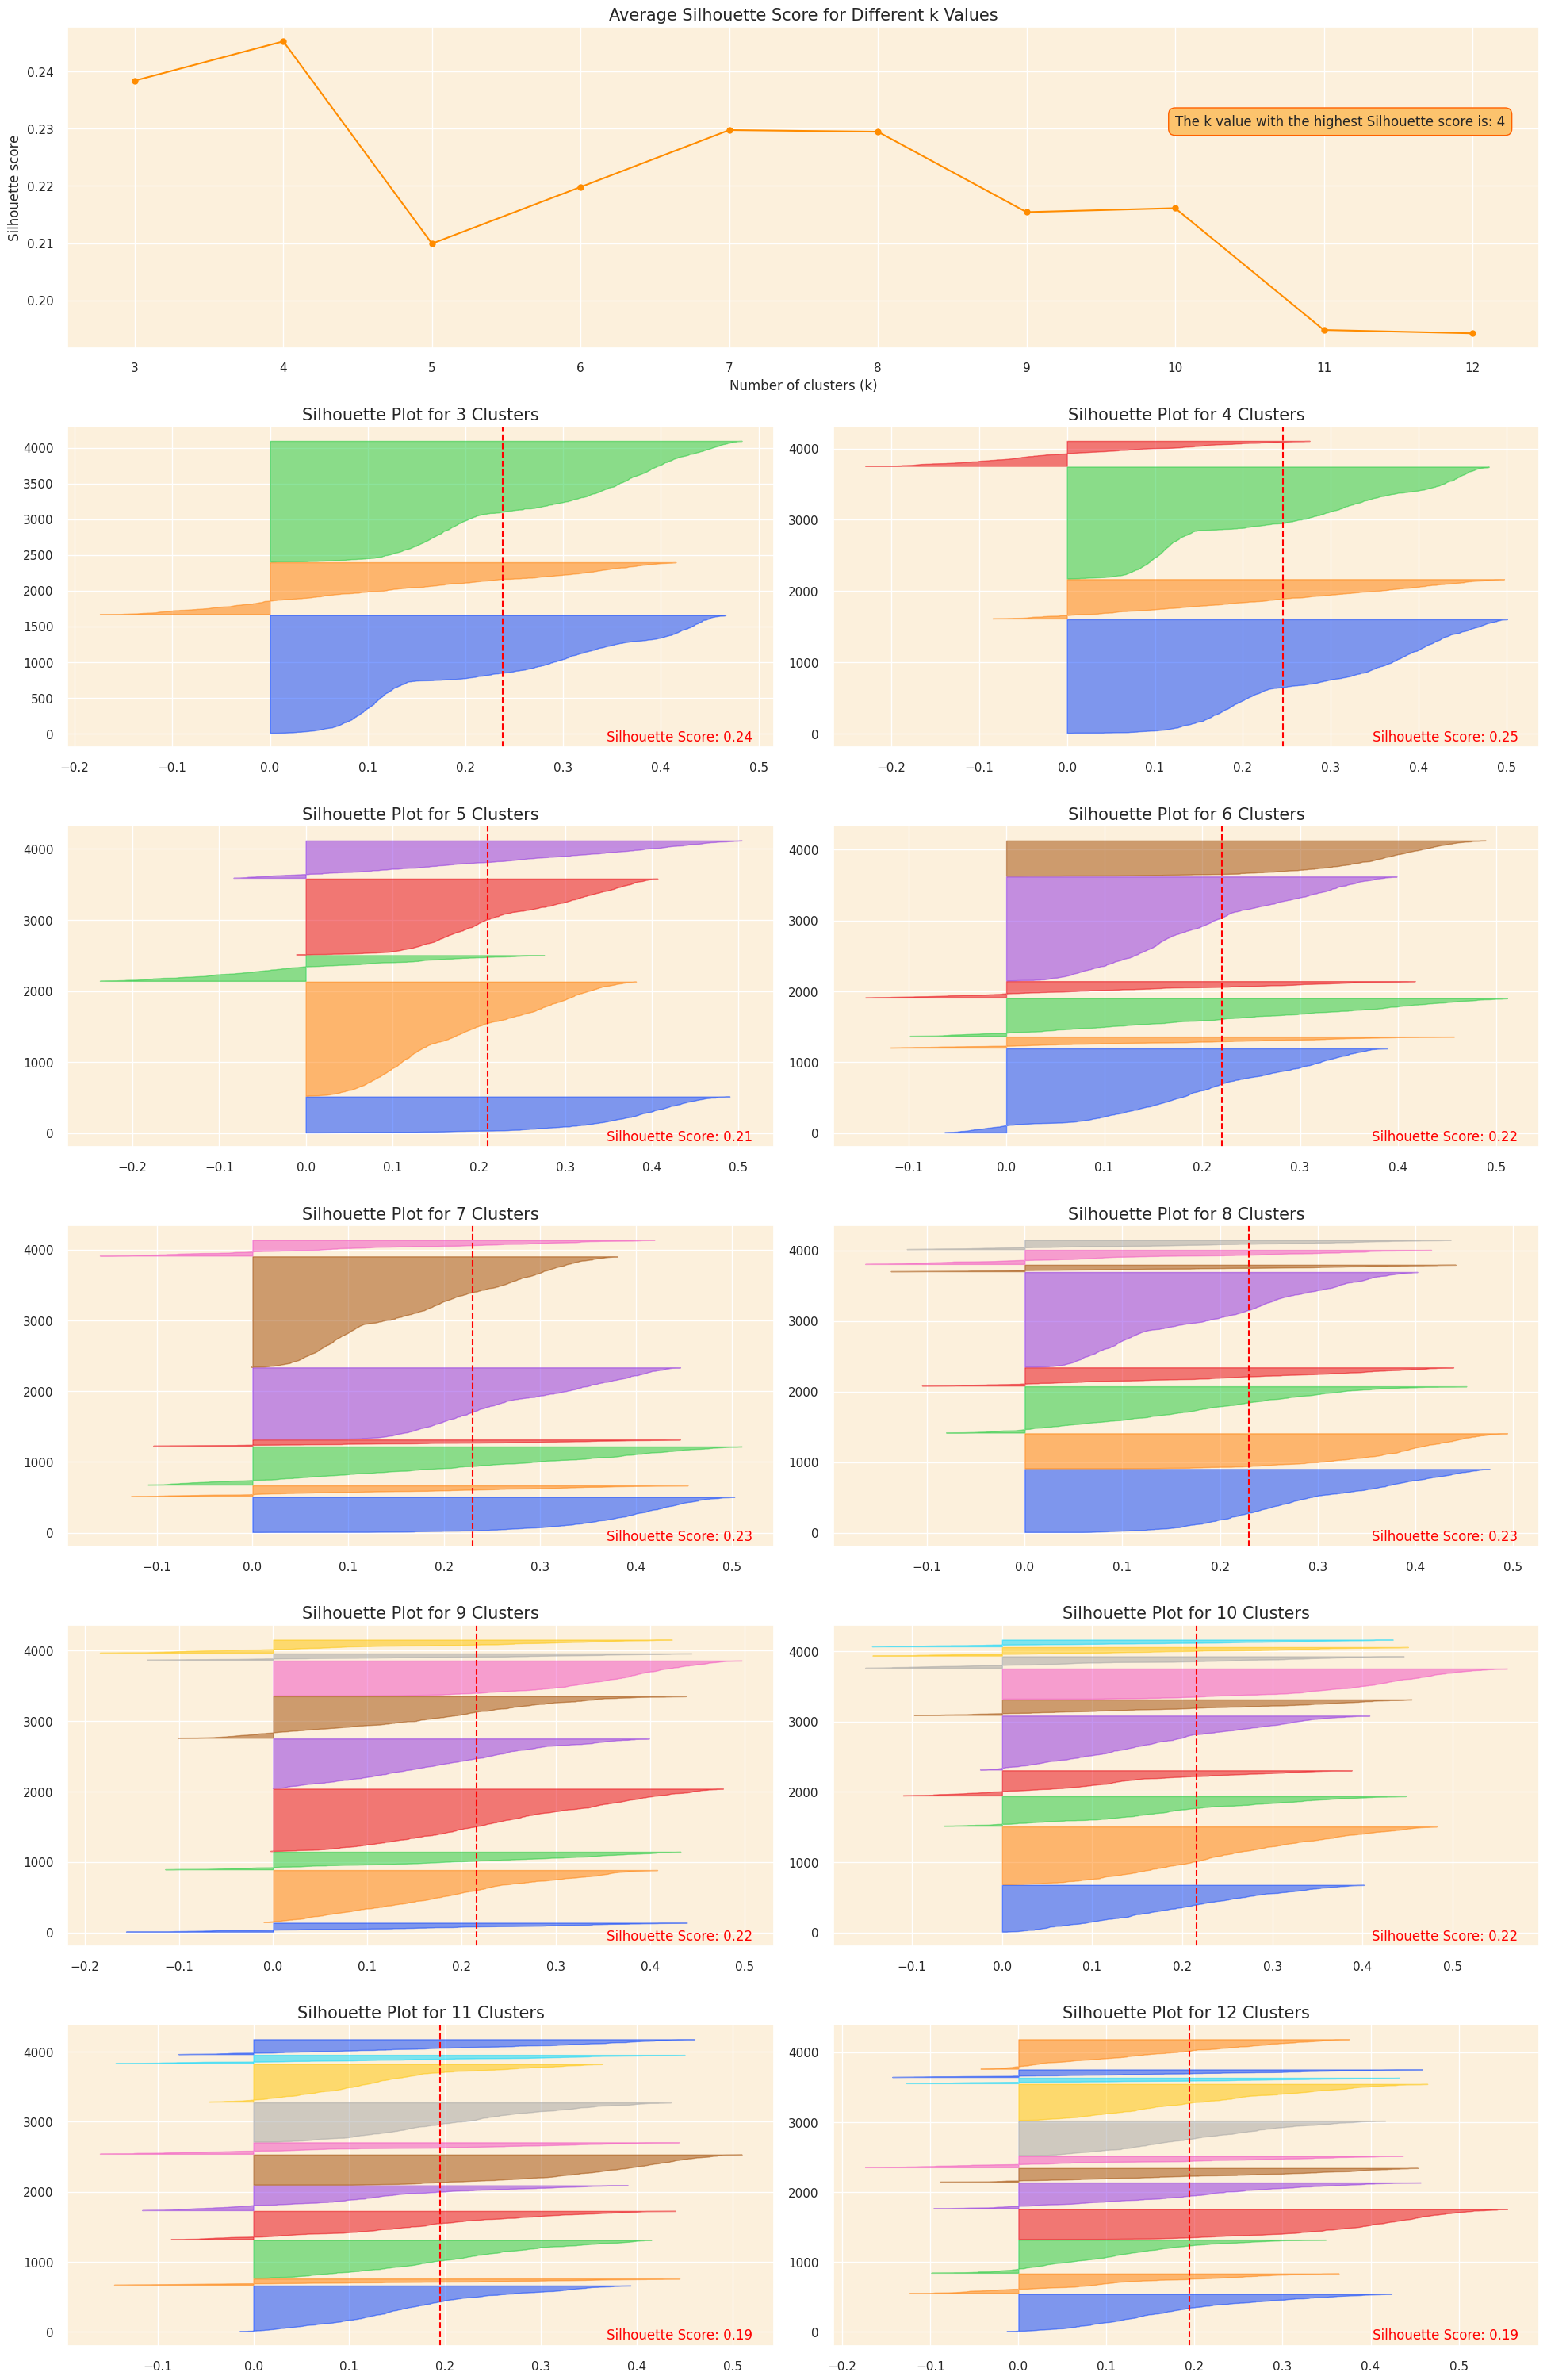

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

<h3 align="left"><font color=#000>Optimal k Value: Silhouette Method Insights</font></h3>

Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing __\( k = 3 \)__ is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

<a id="kmeans_model"></a>
# <b><span style='color:#000'>Step 9.2 |</span><span style='color:#000'> Clustering Model - K-means</span></b>


In [ ]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,294.4,0.0,0.0


<a id="evaluation"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 10 | Clustering Evaluation</p>


<a id="3d_visualization"></a>
# <b><span style='color:#000'>Step 10.1 |</span><span style='color:#000'>  3D Visualization of Top Principal Components</span></b>


In [ ]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [ ]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

<a id="cluster_distributuion"></a>
# <b><span style='color:#000'>Step 10.2 |</span><span style='color:#000'>  Cluster Distribution Visualization</span></b>


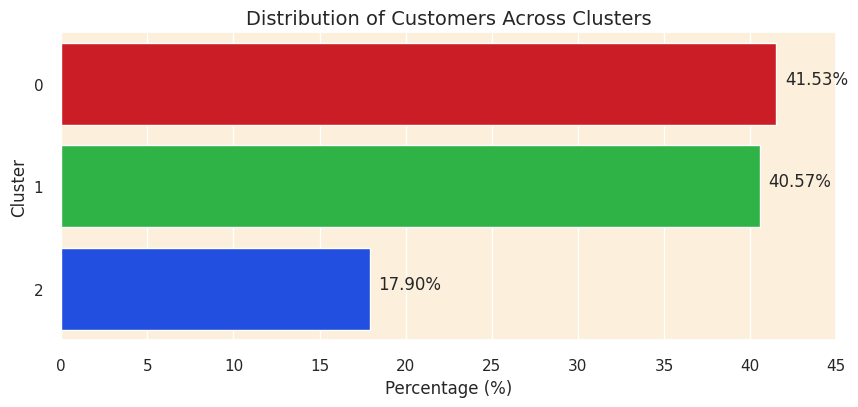

In [ ]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Inference</font></h3>
    
The distribution of customers across the clusters, as depicted by the bar plot, suggests a fairly balanced distribution with clusters 0 and 1 holding around 41% of customers each and cluster 2 accommodating approximately 18% of the customers.

This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers. It implies that each cluster represents a substantial and distinct segment of the customer base, thereby offering valuable insights for future business strategies.

Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data. This setup allows for a more nuanced understanding and analysis of different customer segments, facilitating effective and informed decision-making.


<a id="evaluations_metrics"></a>
# <b><span style='color:#000'>Step 10.3 |</span><span style='color:#000'> Evaluation Metrics</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

To further scrutinize the quality of our clustering, I will employ the following metrics:

- __Silhouette Score__: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.
    
    
- __Calinski Harabasz Score__: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.

    
- __Davies Bouldin Score__: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [ ]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23840228693074256 |
| Calinski Harabasz Score |  1275.742380787339  |
|  Davies Bouldin Score   | 1.3731687976926121  |
+-------------------------+---------------------+


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
<h3 align="left"><font color=#000>Clustering Quality Inference</font></h3>
    
    
- The __Silhouette Score__ of approximately 0.236, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

    
- The __Calinski Harabasz Score__ is 1257.17, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

    
- The __Davies Bouldin Score__ of 1.37 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.


In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.



<a id="profiling"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 11 | Cluster Analysis and Profiling</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
In this section, I am going to analyze the characteristics of each cluster to understand the distinct behaviors and preferences of different customer segments and also profile each cluster to identify the key traits that define the customers in each cluster.

<a id="radar_chart"></a>
# <b><span style='color:#000'>Step 11.1 |</span><span style='color:#000'> Radar Chart Approach</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
First of all, I am going to create radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.To construct the radar charts, it's essential to first compute the centroid for each cluster. This centroid represents the mean value for all features within a specific cluster. Subsequently, I will display these centroids on the radar charts, facilitating a clear visualization of the central tendencies of each feature across the various clusters:

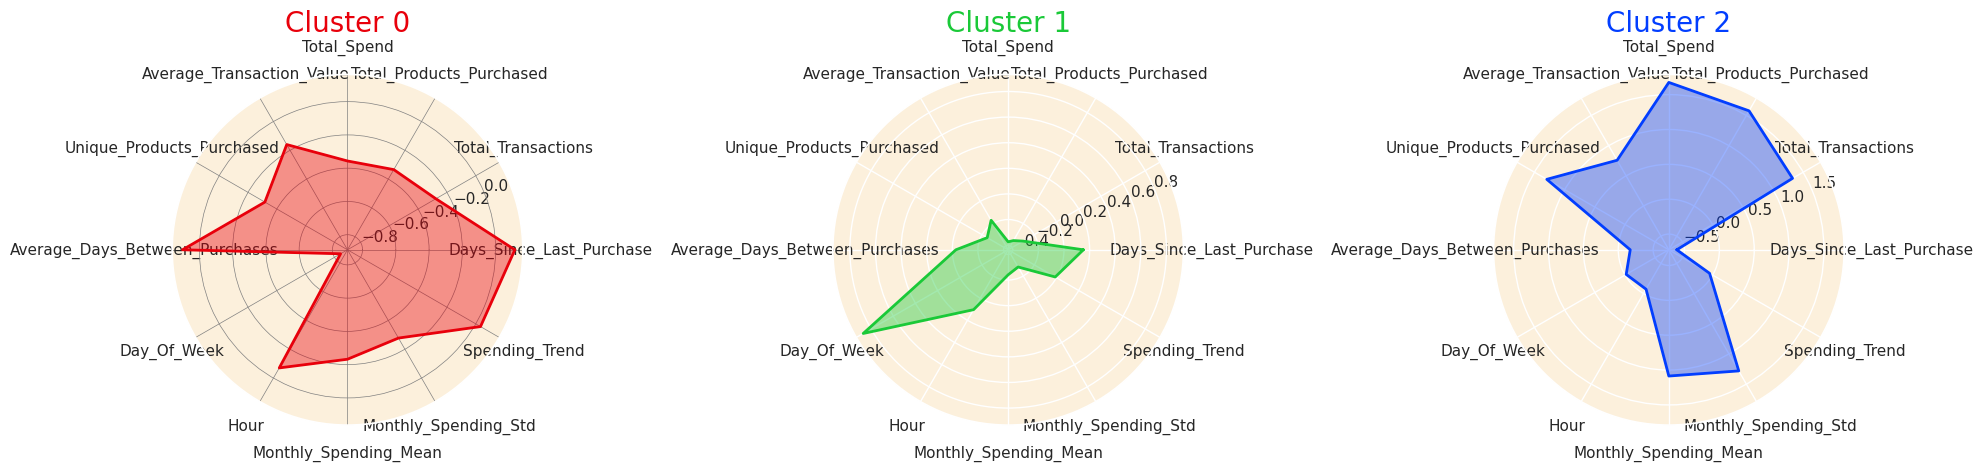

In [ ]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
<h2 align="left"><font color=#000>Customer Profiles Derived from Radar Chart Analysis</font></h2>
    
<h3 align="left"><font color=red>Cluster 0 (Red Chart):</font></h3>

🎯 Profile: __Sporadic Shoppers with a Preference for Weekend Shopping__  

- Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.  
- They have a slight tendency to shop during the weekends, as indicated by the very high `Day_of_Week` value.  
- Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low `Monthly_Spending_Std`).  
- These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.  
- The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.  

____
    
<h3 align="left"><font color=green>Cluster 1 (Green Chart):</font></h3>    

🎯 Profile: __Infrequent Big Spenders with a High Spending Trend__  
    
- Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high `Days_Since_Last_Purchase` and `Average_Days_Between_Purchases`.  
- They have a very high spending trend, indicating that their spending has been increasing over time.  
- These customers prefer shopping late in the day, as indicated by the high `Hour` value, and they mainly reside in the UK.  
- They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.  
- Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.  

____
    
<h3 align="left"><font color=blue>Cluster 2 (Blue Chart):</font></h3>   

🎯 Profile: __Frequent High-Spenders with a High Rate of Cancellations__
    
- Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.  
- They engage in frequent transactions, but also have a high cancellation frequency and rate.  
- These customers have a very low average time between purchases, and they tend to shop early in the day (low `Hour` value).  
- Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.  
- Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.  

<a id="histogram"></a>
# <b><span style='color:#000'>Step 11.2 |</span><span style='color:#000'> Histogram Chart Approach</span></b>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
    
To validate the profiles identified from the radar charts, we can plot histograms for each feature segmented by the cluster labels. These histograms will allow us to visually inspect the distribution of feature values within each cluster, thereby confirming or refining the profiles we have created based on the radar charts.

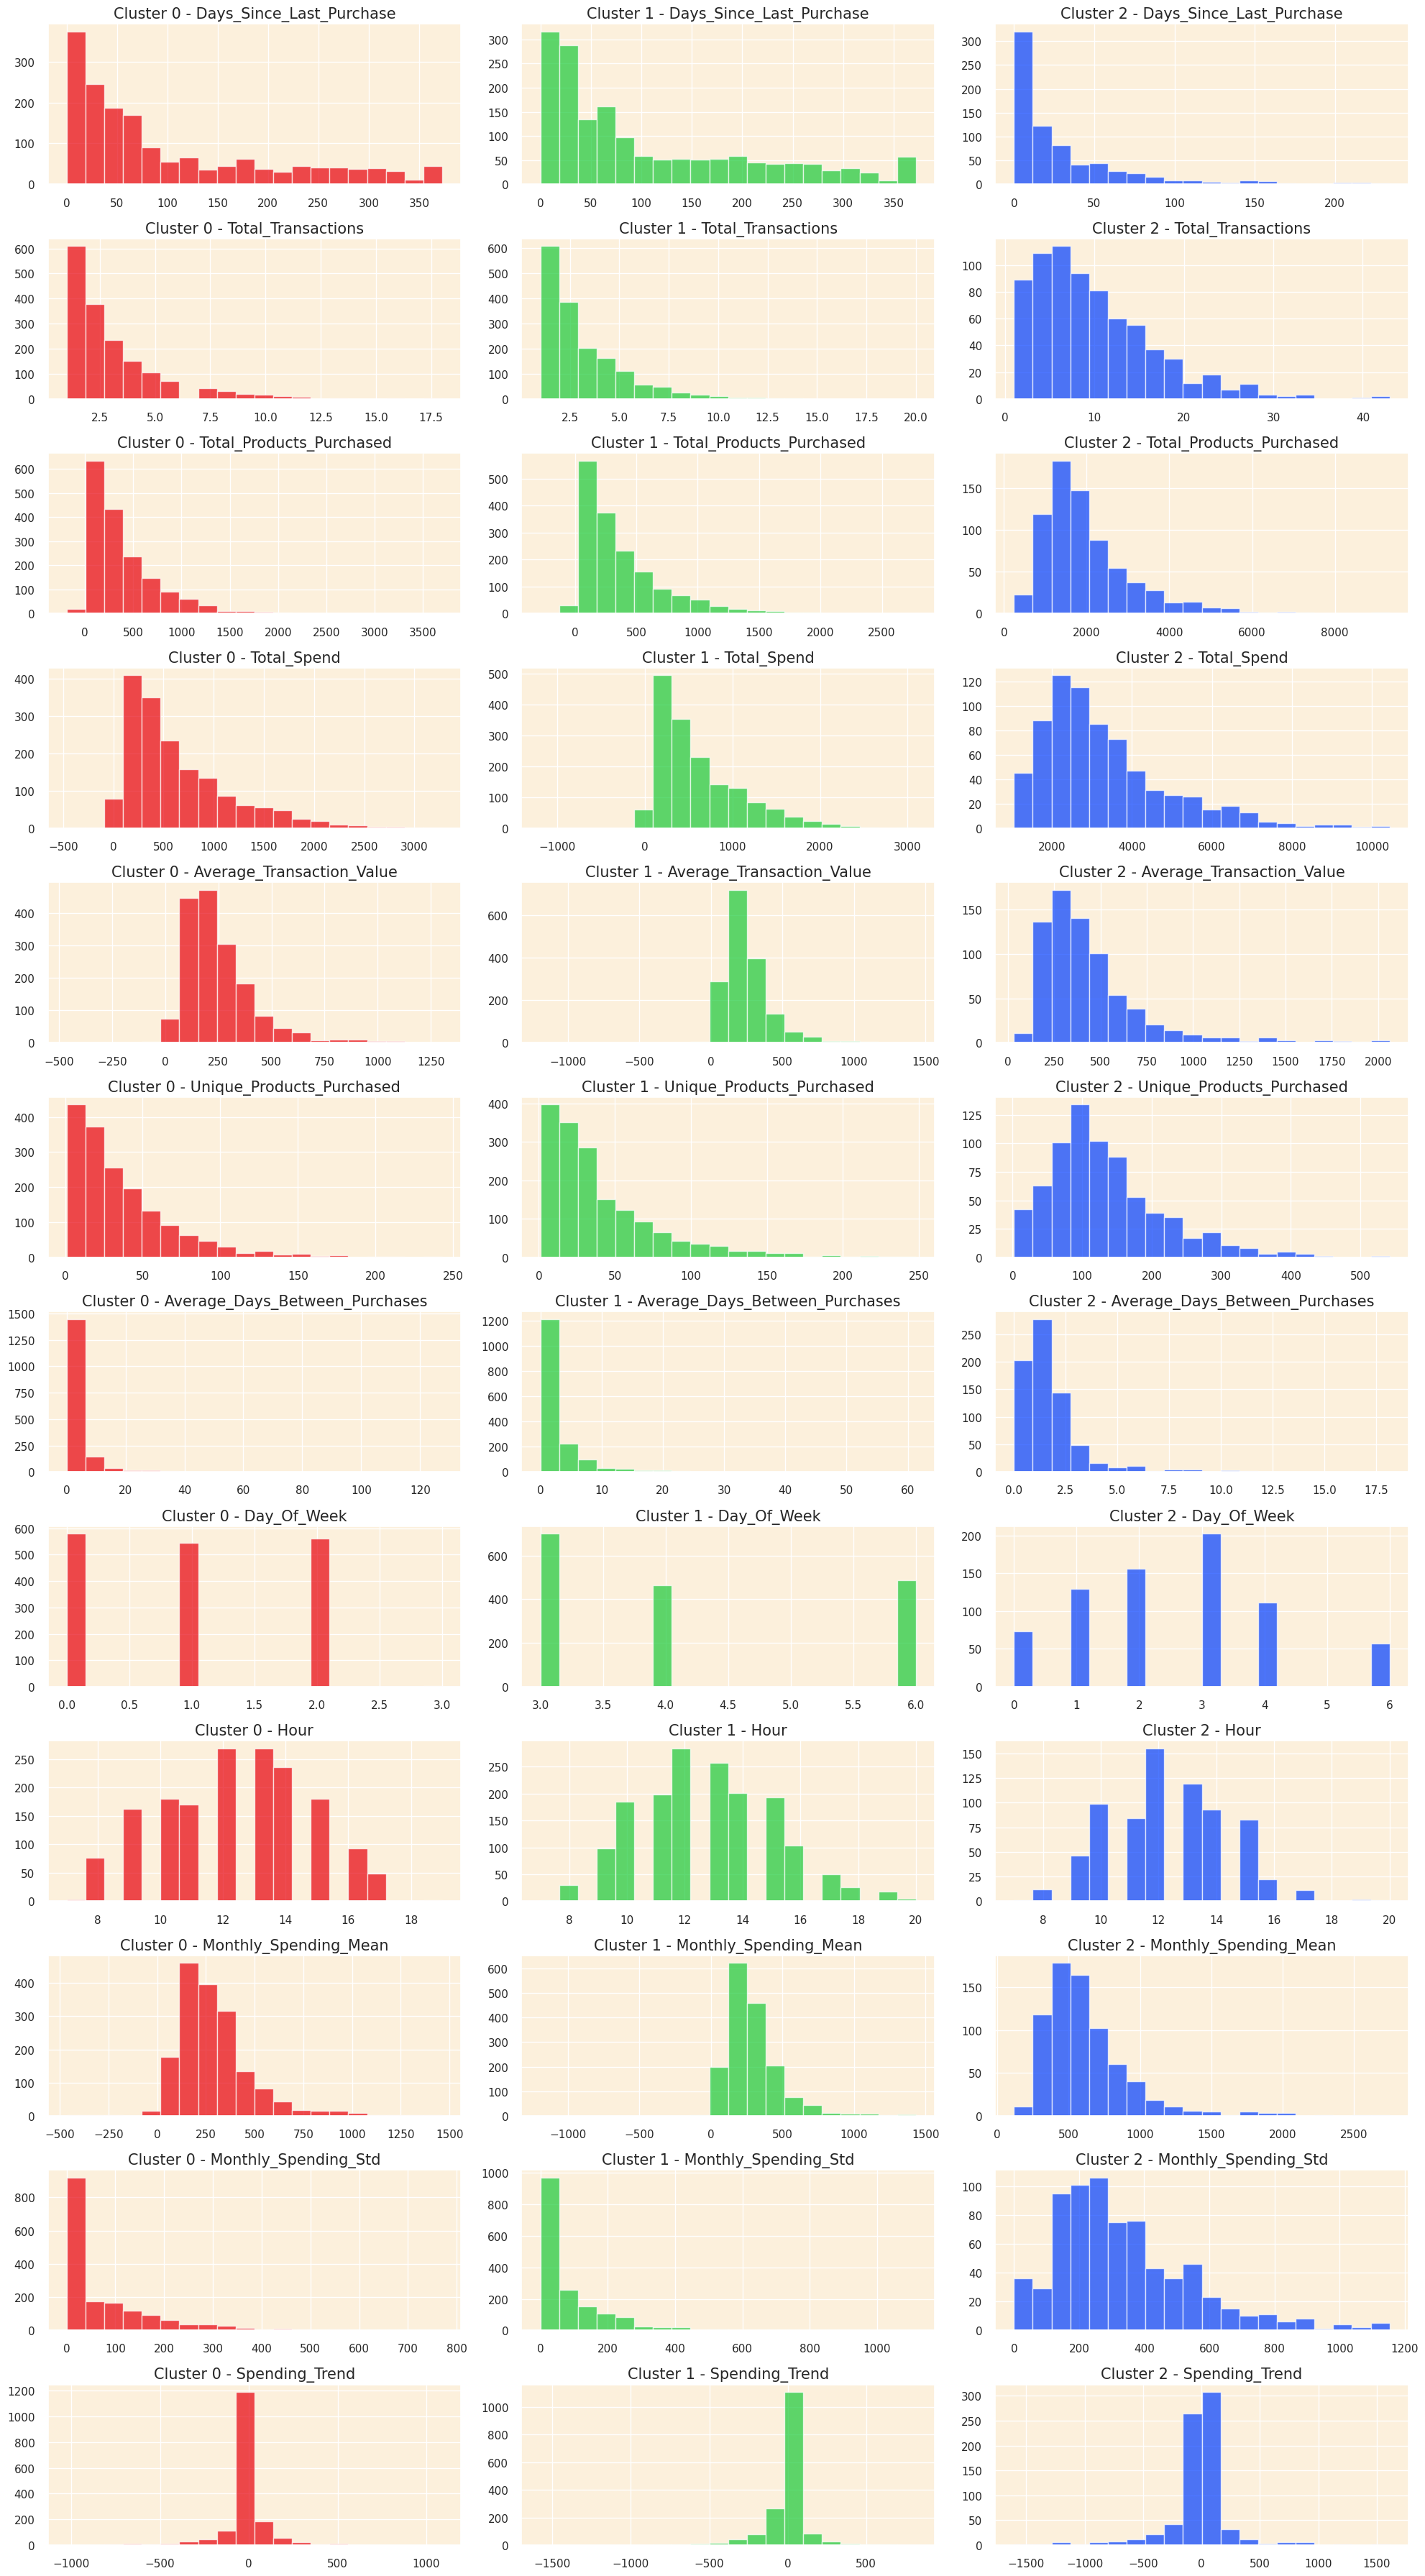

In [ ]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

The detailed insights from the histograms provide a more nuanced understanding of each cluster, helping in refining the profiles to represent the customer behaviors more accurately.

<a id="recommendation_system"></a>
# <p style="font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 12 | Recommendation System</p>


<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">

In the final phase of this project, I am set to develop a recommendation system to enhance the online shopping experience. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. Earlier in the project, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called `outliers_data`.

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting __the top three products__ popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them.

In [ ]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [ ]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
15857.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
15847.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,16014,SMALL CHINESE STYLE SCISSOR
17362.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17324.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
15096.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14375.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
15157.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17542.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
17863.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
